In [1]:
import torch
import random
import os
import pandas as pd
from os import listdir
from os.path import isfile, join
from PIL import Image
import cv2

#from transformers import SegformerConfig, SegformerForSemanticSegmentation

from torchvision import transforms
import torch.nn as nn
import numpy as np
import segmentation_models_pytorch as smp
from IPython.display import clear_output

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("CUDA Available")

CUDA Available


In [22]:
TRAIN_DATA = './data/train/images/'
TRAIN_MASKS = './data/train/masks/'
TEST_DATA = './data/test/'
# IMG_SIZE = (512, 512)
IMG_SIZE = (480, 480)  # scale images to use in batches
TRAIN_DIVISION = True # use all data for training or train/test split
UNET = True
MODEL_PATH = './unet18.pth'
best_eval = None

In [3]:
# normalize to imagenet standard
IMAGE_TRANSFORMS = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),            
        ])


In [4]:
def get_image_names_from_dir(path, full=False):
    ''' Returns list of file names and full paths in directory, 
        if full==False, then list of names only.
    '''
    if full:
        return [os.path.join(path, f) for f in listdir(path) if isfile(join(path, f))]
    else:
        return [f for f in listdir(path) if isfile(join(path, f))]

In [5]:
train_image_names = get_image_names_from_dir(TRAIN_DATA, full=False)
test_image_names = get_image_names_from_dir(TEST_DATA, full=True)

print(f'Train image count: {len(train_image_names)}')
print(f'Test image count:  {len(test_image_names)}')

Train image count: 411
Test image count:  437


In [23]:
class Scaler(object):
    ''' Scale image to requested size, adds mirrored parts to fill edges
        image: image as HWC
        size: width and height tuple (W, H)
    '''
    def __init__(self, size, mask=False):
        self._size = size
        self._padding = 0
        self.mask = mask
    
    def set_padding(self, padding):
        self._padding = padding
        
    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2
        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(image, 
                   (sw, sh),
                   interpolation=cv2.INTER_NEAREST if self.mask else cv2.INTER_AREA,
                   dst=result[offset_y:offset_y + sh, offset_x:offset_x + sw]
                  )
        result[offset_y:offset_y + sh, :offset_x] = result[offset_y:offset_y + sh, offset_x:2 * offset_x][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y:offset_y + sh, offset_x + sw:] = result[offset_y:offset_y + sh, sw + offset_x - offset_end:sw + offset_x][:, ::-1]
        
        result[:offset_y] = result[offset_y:2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh:] = result[sh + offset_y - offset_end:sh + offset_y][::-1]

        return result

In [24]:
def no_aug(image, mask):
    return image, mask   

In [25]:
class AffineAugmenter(object):
    def __init__(self, min_scale=0.9, max_offset=0.1, rotate=True):
        self._min_scale = min_scale
        self._max_offset = max_offset
        self._rotate = rotate

    def __call__(self, image, mask):
        image = np.array(image)  # PIL -> Numpy.
        mask = np.array(mask)
        h, w, c = image.shape
        assert c == 3
        if self._rotate:
            angle = random.random() * np.pi / 2 - np.pi / 4
        else:
            angle = 0
        scale = self._min_scale + random.random() * (1 - self._min_scale)
        rotation = cv2.getRotationMatrix2D(((w // 2), (h // 2)), angle * 180 / np.pi, scale)
        x_offset = random.randint(-int(self._max_offset * w), int(self._max_offset * w))
        y_offset = random.randint(-int(self._max_offset * h), int(self._max_offset * h))
        rotation[:, 2] += [x_offset, y_offset]
        new_image = cv2.warpAffine(image, rotation, (w, h), borderValue=(128, 128, 128))
        new_mask = cv2.warpAffine(mask, rotation, (w, h), borderValue=(0, 0, 0), flags=cv2.INTER_NEAREST)
        return new_image, new_mask  # Numpy -> PIL.


class BrightnessContrastAugmenter(object):
    def __init__(self, brightness=0.3, contrast=0.3):
        self._brightness = brightness
        self._contrast = contrast

    def __call__(self, image, mask):
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        brightness = 2 * (random.random() - 0.5) * self._brightness
        contrast = 1 + 2 * (random.random() - 0.5) * self._contrast
        new_image = image.astype(np.float16)
        new_image += 255 * brightness
        new_image = (new_image - 128) * contrast + 128
        return new_image.clip(0, 255).astype(np.uint8), mask  # Numpy -> PIL.


class BlurAugmenter(object):
    def __init__(self, max_kernel=5):
        self._max_kernel = max_kernel

    def __call__(self, image, mask):
        kernel = random.randint(0, self._max_kernel // 2) * 2 + 1
        if kernel == 1:
            return image, mask
        image = np.array(image)  # PIL -> Numpy.
        h, w, c = image.shape
        assert c == 3
        new_image = cv2.GaussianBlur(image, (kernel, kernel), sigmaX=kernel / 2)
        return new_image.clip(0, 255).astype(np.uint8), mask  # Numpy -> PIL.
    
    
class FlipAugmenter(object):
    def __call__(self, image, mask):
        a = random.randint(0, 3)
        if a == 0:
            image = np.flip(image, axis=0)
            mask = np.flip(mask, axis=0)
        elif a == 1:
            image = np.flip(image, axis=0)
            mask = np.flip(mask, axis=0)
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        elif a == 2:
            image = np.flip(image, axis=1)
            mask = np.flip(mask, axis=1)
        return image, mask


class RandomAugmentation(object):
    def __init__(self, *augmenters):
        self._augmenters = list(augmenters)

    def __call__(self, image, mask):
        augmenter = random.choice(self._augmenters)
        return augmenter(image, mask)

In [26]:
class FlowersDataset(torch.utils.data.Dataset):
    ''' Create dataset to format data, to use in standard Dataloader    
    '''
    def __init__(self, 
                 image_size=IMG_SIZE, 
                 train_img_path=TRAIN_DATA,
                 train_mask_path=TRAIN_MASKS,
                 test_path=TEST_DATA,                
                 augment=False,
                 train=True, 
                 train_fraction=0.85
                ):

        self.path_masks = train_mask_path
        self.path_images = train_img_path   
        self.files = get_image_names_from_dir(self.path_images, full=False)
        self._image_size = np.array(image_size)
        self.transforms = IMAGE_TRANSFORMS
        ids = list(range(len(self.files)))
        random.seed(0)
        random.shuffle(ids)
        train_size = int(len(ids) * train_fraction)
        self._indices = ids[:train_size] if train else ids[train_size:]
        self._image_scaler = Scaler(image_size)
        self._mask_scaler = Scaler(image_size, mask=True)
        if augment:
            self._augmenter = RandomAugmentation(AffineAugmenter(),
                                                 BrightnessContrastAugmenter(),
                                                 BlurAugmenter(),
                                                 FlipAugmenter())
        else:
            self._augmenter = no_aug
        
    def __len__(self):
        return len(self._indices)
    
    def get_train_path(self, name, mask=False):
        if mask:
            return os.path.join(TRAIN_MASKS, name)
        else:
            return os.path.join(TRAIN_DATA, name)
    
    
    def __getitem__(self, idx):
        name = self.files[self._indices[idx]]
        img_name = self.get_train_path(name)
        mask_name = self.get_train_path(name, mask=True)
        
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_name)
        image, mask = self._augmenter(image, mask)
        
        image = self._image_scaler(image)
        mask = self._mask_scaler(mask) 
        mask = mask // 255
        
        image = torch.tensor(image, dtype=torch.float32)        
        mask = torch.tensor(mask, dtype=torch.int64)        
        
        image = image.permute(2, 0, 1)
        mask = mask.permute(2, 0, 1)
        
        image = self.transforms(image)
        
        return image, mask[0] 

In [27]:
# use all data for training or train/test split
if TRAIN_DIVISION:
    trainset = FlowersDataset(IMG_SIZE, train=True, augment=True, train_fraction=0.85)
    valset = FlowersDataset(IMG_SIZE, train=False)
else:
    trainset = FlowersDataset(IMG_SIZE, train=True, augment=True, train_fraction=1.)
    valset = trainset
print("Image size:", IMG_SIZE)
print("Train set size:", len(trainset))
print("Validation set size:", len(valset))

Image size: (480, 480)
Train set size: 349
Validation set size: 62


In [11]:
class BCELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self._bce = torch.nn.BCEWithLogitsLoss()
        
    def __call__(self, predicted, masks):
        b, c, h, w = predicted.shape
        if c != 1:
            raise ValueError("{} not for multiclass classification".format(type(self)))
            
        # predicted: float32, BCHW.
        # masks: long, BHW.            

        predicted = torch.sigmoid(predicted)        
        loss = self._bce(predicted[:, 0], masks.float())
        return loss

In [12]:
def make_optimizer(model, lr=3e-4):
    return torch.optim.Adam(model.parameters(), lr=lr)

In [13]:
def train_loop(model, optimizer, loss, train_loader, 
               n_iter, lr_scheduler=None, plot=None, 
               plot_kwargs={}, use_cuda=False, plot_steps=10):
    model.train()
    losses = []

    for i, (images, masks) in enumerate(train_loader):
        if i == n_iter:
            break
        if use_cuda:
            images = images.cuda()
            masks = masks.cuda()

        predicted = model(images)
        optimizer.zero_grad()
        loss_value = loss(predicted, masks)



        loss_value.backward()
        optimizer.step()
        if lr_scheduler is not None:
            lr_scheduler.step()

        losses.append(loss_value.item())
        if i % 10 == 0:
            print("Step {} / {}, loss: {:.4f}, learning rate: {:.4f}\r".format(i, n_iter, loss_value.item(), optimizer.param_groups[0]["lr"]), end="")
    print(" " * 50 + "\r", end="")
    print("Train loss: {:.4f}, learning rate: {:.5f}".format(np.mean(losses[-plot_steps:]), optimizer.param_groups[0]["lr"]))
    return np.mean(losses)

In [19]:
def eval_model(model, loss, testset, batch_size,
               use_cuda=False,
               num_workers=1):
    model.eval()
    clear_output()
    kwargs = {}
    if use_cuda:
        kwargs["pin_memory"] = True

    test_loader = torch.utils.data.DataLoader(
        testset, 
        batch_size=batch_size,
        num_workers=0
    ) #, **kwargs)
    
    losses = []
    with torch.no_grad():
        for images, masks in test_loader:
            if use_cuda:
                images = images.cuda()
                masks = masks.cuda()    
            predicted = model(images)

            loss_value = loss(predicted, masks)            
            losses.append(loss_value.item())

    test_loss = np.mean(losses)
    print("Test loss:", test_loss)
    return test_loss

In [16]:
# Unet based on resnet18, random weights - for baseline
model = smp.Unet("resnet18", encoder_weights=None, classes=1)

model.eval()
sample_input = torch.zeros((1, 3, *IMG_SIZE))
if USE_CUDA:
    sample_input = sample_input.cuda()
    model.cuda()
with torch.no_grad():
    sample_output = model(sample_input)

In [17]:
loss_fn = BCELoss

batch_size = 4
n_iters = 3000
eval_steps = 1500
loss_storage = []
train_loss_storage = []
loss = loss_fn()

if USE_CUDA:
    model.cuda()
    loss.cuda()
    
optimizer = make_optimizer(model)

In [28]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                    shuffle=True, num_workers=0)
eval_loss = eval_model(model, loss, valset, batch_size, use_cuda=USE_CUDA)
loss_storage.append(eval_loss)

Test loss: 0.6943618953227997


In [29]:
epoch = 0
if best_eval is None:
    best_eval = 1000

In [30]:
%%time
num_epochs = 15
while epoch < num_epochs:
    i = 0
    while i < n_iters:    
        train_steps = min(eval_steps, n_iters - i)
        train_loss = train_loop(model, optimizer, loss, train_loader, train_steps,
                   lr_scheduler=None,
                   use_cuda=USE_CUDA)
        i += train_steps
    eval_loss = eval_model(model, loss, valset, batch_size,
                           use_cuda=USE_CUDA)
    if eval_loss < best_eval:
        best_eval = eval_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': eval_loss,
            }, MODEL_PATH)
        print('Saving...')
    print(f'Epoch: {epoch+1}')
    loss_storage.append(eval_loss)
    train_loss_storage.append(train_loss)
    epoch = epoch + 1

Test loss: 0.6167353689670563
Epoch: 11


KeyboardInterrupt: 

In [31]:
loss_storage

[0.6943384455245676,
 0.6943618953227997,
 0.6407120004296303,
 0.6280145980417728,
 0.6265756636857986,
 0.6218168213963509,
 0.6275148876011372,
 0.6263148672878742,
 0.6184479594230652,
 0.617865651845932,
 0.6154147088527679,
 0.6155517585575581,
 0.6167353689670563]

In [32]:
scaler = Scaler(IMG_SIZE)
def get_test_image(name):
        image = cv2.imread(name)    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = scaler(image)
        image = torch.tensor(image, dtype=torch.float32)        
        image = image.permute(2, 0, 1)        
        image = IMAGE_TRANSFORMS(image)
        return image #.unsqueeze(0)

In [33]:
def image_to_numpy(image):
    ''' Convert Torch tensor to Numpy image.
    '''
    if isinstance(image, np.ndarray):
        return image
    if image.dtype == torch.float32:
        image = image - image.min()
        image = 255 * image / max(1e-6, image.max())
    return image.to(torch.uint8).permute(1, 2, 0).cpu().numpy()

In [34]:
def rle_encoding(x): # for submission
    ''' x: numpy array of shape (height, width), 1 - mask, 0 - background
        Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[
        0
    ]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [35]:
def reshape_to_original(name, mask): 
    ''' Return mask to shape of original image
    '''
    h, w, c = cv2.imread(name).shape
    
    mh, mw = mask.shape
    s = max(h, w)
    offset = (max(h, w) - min(h, w)) // 2
    offset2 = (max(h, w) - min(h, w)) - offset
    mask = cv2.resize(mask, 
                      (s, s),
                      interpolation=cv2.INTER_NEAREST,
                      )
    if offset2 == 0:
        return mask
    if h < w:
        mask = mask[offset:-offset2, :]
    else:
        mask = mask[:, offset:-offset2]
    return mask

In [36]:
def show_masked(name, predicted_labels):
    ''' Display masked image
    '''
    image = cv2.imread(name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = (predicted_labels > 0)[..., None]
    display(Image.fromarray(image * mask))    

In [66]:
def get_pred(model, img_name, full_path=False, verbose=True, treshold=0.01):
    image = get_test_image(img_name)
    with torch.no_grad():
        if USE_CUDA:
            
            predicted = model(image.unsqueeze(0).cuda())[0]  # CHW.
        else:
            predicted = model(image.unsqueeze(0))[0]  

        predicted = torch.sigmoid(predicted[0])
        
        predicted_labels = predicted > treshold

        if verbose:
            aggregated = aggregated.cpu().numpy()
            predicted_labels = predicted_labels.cpu().numpy().astype(np.uint8)
            image = image_to_numpy(image)
            mask = (predicted_labels > 0)[..., None]
            selected = image * mask #+ 255 * (1 - mask)
            display(Image.fromarray(image))
            display(Image.fromarray(selected))
            display(Image.fromarray(predicted_labels*100))
            
        return predicted_labels.cpu().numpy().astype(np.uint8)

./data/test/image_ecf9e914.png


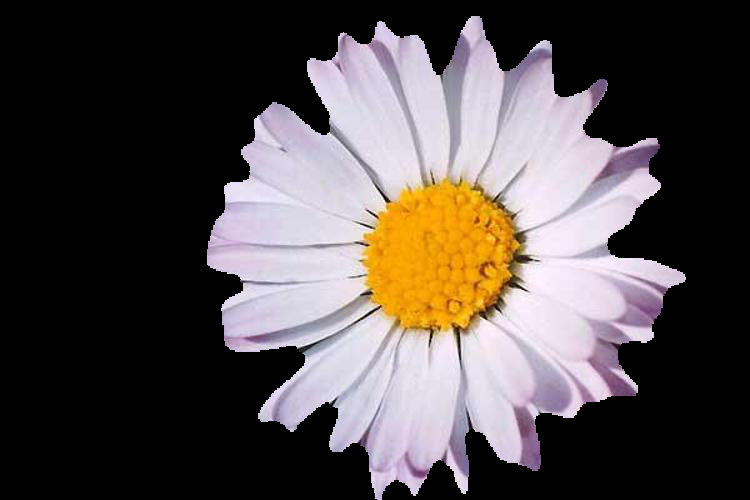

./data/test/image_ecf9eab8.png


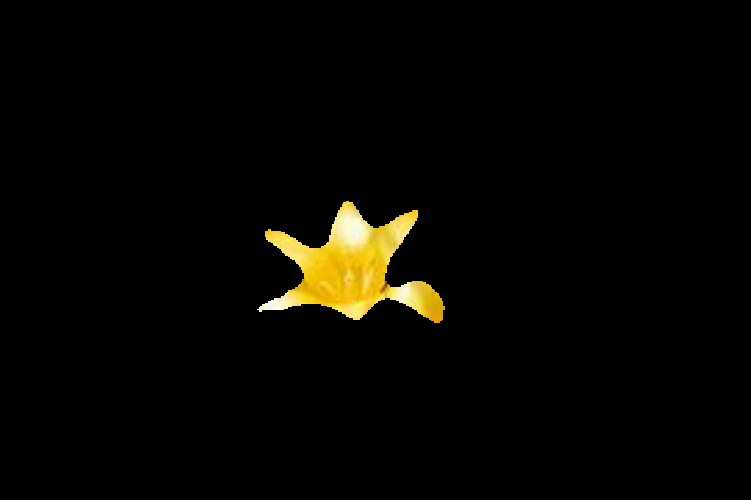

./data/test/image_ecf9eba8.png


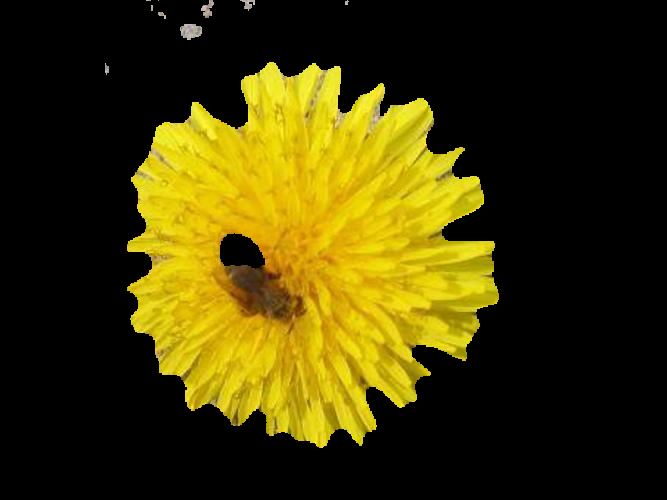

./data/test/image_ecf9ee3c.png


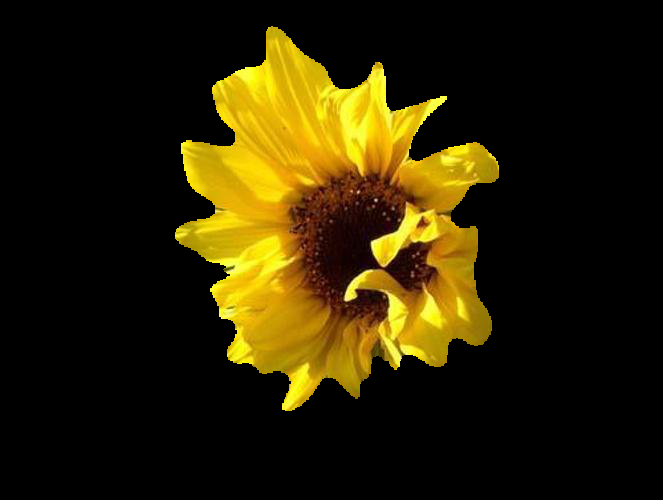

./data/test/image_ecf9eee6.png


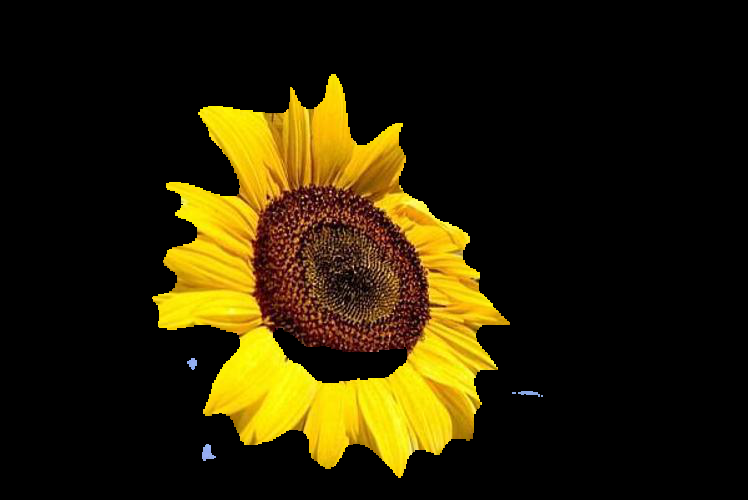

In [67]:
submission = {"ImageId": [], "EncodedPixels": []}
model.eval()
for name in test_image_names[:5]:
    print(name)
    with torch.no_grad():
        result = get_pred(model, name, verbose=False) #.cpu()
        mask = reshape_to_original(name, result)
        show_masked(name, mask)
        submission["ImageId"].append(str(name[-18:-4]))
        submission["EncodedPixels"].append(rle_encoding(mask))       
    

In [56]:
pd.DataFrame(submission).to_csv("submission.csv", index=False)